Week 11: DBSCAN and Hierarchical Clustering for NFL Injury Prevention Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA

# Set random seed
np.random.seed(42)

Data Preparation

In [2]:
# Load data 
try:
    injury_data = pd.read_csv('data/InjuryRecord.csv')
    video_data = pd.read_csv('data/video_review.csv') 
    plays_data = pd.read_csv('data/plays.csv')
    
    print(f" All datasets loaded successfully")
    print(f" InjuryRecord: {injury_data.shape[0]} records, {injury_data.shape[1]} columns")
    print(f" VideoReview: {video_data.shape[0]} records, {video_data.shape[1]} columns")
    print(f" PlaysData: {plays_data.shape[0]} records, {plays_data.shape[1]} columns")
except FileNotFoundError as e:
    print(f" Error loading files: {e}")
    print(" Trying alternative paths and creating sample data...")
    try:
        injury_data = pd.read_csv('data/InjuryRecord.csv')
        video_data = pd.read_csv('data/video_review.csv') 
        plays_data = pd.read_csv('data/plays.csv')
        print(f" All datasets loaded from data/ folder")
    except FileNotFoundError:
        print(" Creating enhanced sample data for density-based clustering analysis...")
        injury_data = pd.DataFrame({
            'PlayerKey': range(1, 106),
            'GameID': [f'{i}-{j}' for i in range(1, 106) for j in [1]],
            'PlayKey': [f'{i}-{j}-{k}' for i in range(1, 106) for j in [1] for k in [1]],
            'BodyPart': np.random.choice(['Knee', 'Ankle', 'Foot', 'Toes', 'Heel'], 105, p=[0.46, 0.40, 0.07, 0.06, 0.01]),
            'Surface': np.random.choice(['Natural', 'Synthetic'], 105, p=[0.46, 0.54]),
            'DM_M1': np.ones(105),  # All miss at least 1 day
            'DM_M7': np.random.choice([0, 1], 105, p=[0.28, 0.72]),
            'DM_M28': np.random.choice([0, 1], 105, p=[0.65, 0.35]),
            'DM_M42': np.random.choice([0, 1], 105, p=[0.72, 0.28])
        })
        video_data = pd.DataFrame({
            'Season_Year': [2016] * 37,
            'GameKey': range(1, 38),
            'PlayID': range(1, 38),
            'GSISID': range(1, 38),
            'Player_Activity_Derived': np.random.choice(['Tackling', 'Blocking', 'Tackled', 'Blocked'], 37, p=[0.35, 0.27, 0.16, 0.22]),
            'Turnover_Related': np.random.choice(['No', 'Yes'], 37, p=[0.9, 0.1]),
            'Primary_Impact_Type': np.random.choice(['Helmet-to-body', 'Helmet-to-helmet', 'Helmet-to-ground', 'Unclear'], 37, p=[0.46, 0.46, 0.05, 0.03]),
            'Friendly_Fire': np.random.choice(['No', 'Yes'], 37, p=[0.84, 0.16])
        })
        plays_data = pd.DataFrame({
            'gameId': range(2021090900, 2021090900 + 8557),
            'playId': range(1, 8558),
            'quarter': np.random.choice([1, 2, 3, 4], 8557, p=[0.25, 0.25, 0.25, 0.25]),
            'down': np.random.choice([1, 2, 3, 4], 8557, p=[0.35, 0.25, 0.25, 0.15]),
            'yardsToGo': np.random.randint(1, 21, 8557),
            'possessionTeam': np.random.choice(['TB', 'DAL', 'NE', 'KC', 'GB', 'SF'], 8557),
            'defensiveTeam': np.random.choice(['TB', 'DAL', 'NE', 'KC', 'GB', 'SF'], 8557),
            'offenseFormation': np.random.choice(['SHOTGUN', 'SINGLEBACK', 'EMPTY', 'I_FORM', 'PISTOL'], 8557, p=[0.64, 0.14, 0.16, 0.03, 0.03]),
            'personnelO': np.random.choice(['1 RB, 1 TE, 3 WR', '1 RB, 2 TE, 2 WR', '2 RB, 1 TE, 2 WR'], 8557, p=[0.6, 0.25, 0.15]),
            'defendersInBox': np.random.randint(4, 9, 8557),
            'absoluteYardlineNumber': np.random.randint(1, 101, 8557),
            'pff_playAction': np.random.choice([0, 1], 8557, p=[0.85, 0.15]),
            'passResult': np.random.choice(['C', 'I', 'S'], 8557, p=[0.65, 0.25, 0.1])
        })
        print(f" Enhanced sample datasets created for clustering analysis")

## Enhanced Dataset Overview

print(f"\n=== ENHANCED INJURY DATA OVERVIEW ===")
print(f"Columns: {list(injury_data.columns)}")
print(f"Body parts: {injury_data['BodyPart'].value_counts().to_dict()}")
print(f"Surfaces: {injury_data['Surface'].value_counts().to_dict()}")

print(f"\n=== ENHANCED VIDEO REVIEW DATA OVERVIEW ===")
print(f"Columns: {list(video_data.columns)}")
if 'Player_Activity_Derived' in video_data.columns:
    print(f"Player activities: {video_data['Player_Activity_Derived'].value_counts().to_dict()}")
if 'Primary_Impact_Type' in video_data.columns:
    print(f"Impact types: {video_data['Primary_Impact_Type'].value_counts().to_dict()}")

print(f"\n=== ENHANCED PLAYS DATA OVERVIEW ===")
print(f"Columns: {list(plays_data.columns[:15])}...") # Show first 15 columns
if 'possessionTeam' in plays_data.columns:
    print(f"Unique teams: {len(plays_data['possessionTeam'].dropna().unique())}")
if 'offenseFormation' in plays_data.columns:
    print(f"Formations: {plays_data['offenseFormation'].value_counts().head().to_dict()}")


 All datasets loaded successfully
 InjuryRecord: 105 records, 9 columns
 VideoReview: 37 records, 10 columns
 PlaysData: 8557 records, 32 columns

=== ENHANCED INJURY DATA OVERVIEW ===
Columns: ['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
Body parts: {'Knee': 48, 'Ankle': 42, 'Foot': 7, 'Toes': 7, 'Heel': 1}
Surfaces: {'Synthetic': 57, 'Natural': 48}

=== ENHANCED VIDEO REVIEW DATA OVERVIEW ===
Columns: ['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Player_Activity_Derived', 'Turnover_Related', 'Primary_Impact_Type', 'Primary_Partner_GSISID', 'Primary_Partner_Activity_Derived', 'Friendly_Fire']
Player activities: {'Tackling': 13, 'Blocked': 10, 'Blocking': 8, 'Tackled': 6}
Impact types: {'Helmet-to-body': 17, 'Helmet-to-helmet': 17, 'Helmet-to-ground': 2, 'Unclear': 1}

=== ENHANCED PLAYS DATA OVERVIEW ===
Columns: ['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide'

Feature Engineering for Advanced Clustering

In [3]:
def create_advanced_clustering_features(injury_df, video_df, plays_df):
    """
    Create comprehensive features optimized for DBSCAN and Hierarchical clustering
    Focus on density-based patterns and hierarchical injury relationships
    """
    df = injury_df.copy()
    
    # === CORE INJURY FEATURES ===
    # Body part features (binary for density analysis)
    df['foot_injury'] = (df['BodyPart'] == 'Foot').astype(int)
    df['ankle_injury'] = (df['BodyPart'] == 'Ankle').astype(int)
    df['knee_injury'] = (df['BodyPart'] == 'Knee').astype(int)
    df['toes_injury'] = (df['BodyPart'] == 'Toes').astype(int)
    df['heel_injury'] = (df['BodyPart'] == 'Heel').astype(int)
    
    # Surface features
    df['natural_surface'] = (df['Surface'] == 'Natural').astype(int)
    df['synthetic_surface'] = (df['Surface'] == 'Synthetic').astype(int)
    
    # Recovery timeline features (critical for hierarchical structure)
    df['dm_m1'] = df['DM_M1'].fillna(0)
    df['dm_m7'] = df['DM_M7'].fillna(0)
    df['dm_m28'] = df['DM_M28'].fillna(0)
    df['dm_m42'] = df['DM_M42'].fillna(0)
    
    # Advanced recovery metrics for clustering
    df['recovery_intensity'] = df['dm_m1'] + df['dm_m7'] + df['dm_m28'] + df['dm_m42']
    df['recovery_severity_weighted'] = (df['dm_m1'] * 1 + df['dm_m7'] * 2 + 
                                        df['dm_m28'] * 4 + df['dm_m42'] * 8)
    df['recovery_persistence'] = (df['dm_m28'] + df['dm_m42']).astype(float)
    df['immediate_recovery'] = ((df['dm_m1'] == 1) & (df['dm_m7'] == 0)).astype(int)
    df['extended_recovery'] = (df['dm_m42'] == 1).astype(int)
    df['recovery_profile_score'] = (df['dm_m7'] * 0.3 + df['dm_m28'] * 0.5 + df['dm_m42'] * 0.2)
    
    # === VIDEO ANALYSIS FEATURES ===
    if len(video_df) > 0 and 'Primary_Impact_Type' in video_df.columns:
        # Calculate comprehensive impact statistics
        impact_stats = video_df['Primary_Impact_Type'].value_counts(normalize=True)
        activity_stats = video_df['Player_Activity_Derived'].value_counts(normalize=True)
        
        # Impact severity metrics
        helmet_to_helmet_risk = impact_stats.get('Helmet-to-helmet', 0.46)
        helmet_to_body_risk = impact_stats.get('Helmet-to-body', 0.46)
        helmet_to_ground_risk = impact_stats.get('Helmet-to-ground', 0.05)
        unclear_impact_risk = impact_stats.get('Unclear', 0.03)
        
        # Activity-based risk profiles
        tackling_activity_rate = activity_stats.get('Tackling', 0.35)
        blocking_activity_rate = activity_stats.get('Blocking', 0.27)
        tackled_activity_rate = activity_stats.get('Tackled', 0.16)
        blocked_activity_rate = activity_stats.get('Blocked', 0.22)
        
        # Advanced impact metrics
        if 'Friendly_Fire' in video_df.columns:
            friendly_fire_rate = (video_df['Friendly_Fire'] == 'Yes').mean()
        else:
            friendly_fire_rate = 0.16
            
        if 'Turnover_Related' in video_df.columns:
            turnover_context_rate = (video_df['Turnover_Related'] == 'Yes').mean()
        else:
            turnover_context_rate = 0.1
            
    else:
        # Default comprehensive values
        helmet_to_helmet_risk = 0.46
        helmet_to_body_risk = 0.46
        helmet_to_ground_risk = 0.05
        unclear_impact_risk = 0.03
        tackling_activity_rate = 0.35
        blocking_activity_rate = 0.27
        tackled_activity_rate = 0.16
        blocked_activity_rate = 0.22
        friendly_fire_rate = 0.16
        turnover_context_rate = 0.1
    
    # Add video-derived density features
    n_samples = len(df)
    df['helmet_impact_density'] = np.full(n_samples, helmet_to_helmet_risk + helmet_to_body_risk)
    df['severe_impact_risk'] = np.full(n_samples, helmet_to_helmet_risk + helmet_to_ground_risk)
    df['contact_sport_intensity'] = np.full(n_samples, tackling_activity_rate + blocking_activity_rate)
    df['vulnerability_exposure'] = np.full(n_samples, tackled_activity_rate + blocked_activity_rate)
    df['team_dynamics_risk'] = np.full(n_samples, friendly_fire_rate)
    df['game_intensity_factor'] = np.full(n_samples, turnover_context_rate)
    df['impact_uncertainty'] = np.full(n_samples, unclear_impact_risk)
    
    # Simulate specific impact characteristics for hierarchical analysis
    df['simulated_severe_impact'] = np.random.binomial(1, helmet_to_helmet_risk + helmet_to_ground_risk, n_samples)
    df['simulated_team_collision'] = np.random.binomial(1, friendly_fire_rate, n_samples)
    df['simulated_high_intensity'] = np.random.binomial(1, turnover_context_rate + tackling_activity_rate, n_samples)
    
    # === PLAY CONTEXT FEATURES ===
    if len(plays_df) > 0 and 'offenseFormation' in plays_df.columns:
        # Formation density analysis
        formation_stats = plays_df['offenseFormation'].value_counts(normalize=True)
        
        # Formation clustering characteristics
        spread_formation_rate = formation_stats.get('SHOTGUN', 0.64) + formation_stats.get('EMPTY', 0.16)
        power_formation_rate = formation_stats.get('SINGLEBACK', 0.14) + formation_stats.get('I_FORM', 0.03)
        specialty_formation_rate = formation_stats.get('PISTOL', 0.03)
        
        # Defensive and situational metrics
        if 'defendersInBox' in plays_df.columns:
            avg_defensive_pressure = plays_df['defendersInBox'].mean()
            defensive_pressure_variance = plays_df['defendersInBox'].std()
        else:
            avg_defensive_pressure = 6.5
            defensive_pressure_variance = 1.2
            
        # Play complexity and situational factors
        if 'pff_playAction' in plays_df.columns:
            play_action_complexity = plays_df['pff_playAction'].mean()
        else:
            play_action_complexity = 0.15
            
        # Field position clustering
        if 'absoluteYardlineNumber' in plays_df.columns:
            red_zone_density = (plays_df['absoluteYardlineNumber'] >= 80).mean()
            defensive_zone_density = (plays_df['absoluteYardlineNumber'] <= 20).mean()
            midfield_density = ((plays_df['absoluteYardlineNumber'] > 20) & 
                               (plays_df['absoluteYardlineNumber'] < 80)).mean()
        else:
            red_zone_density = 0.1
            defensive_zone_density = 0.1
            midfield_density = 0.8
            
    else:
        # Default values for comprehensive analysis
        spread_formation_rate = 0.8
        power_formation_rate = 0.17
        specialty_formation_rate = 0.03
        avg_defensive_pressure = 6.5
        defensive_pressure_variance = 1.2
        play_action_complexity = 0.15
        red_zone_density = 0.1
        defensive_zone_density = 0.1
        midfield_density = 0.8
    
    # Add play context density features
    df['formation_spread_density'] = np.full(n_samples, spread_formation_rate)
    df['formation_power_density'] = np.full(n_samples, power_formation_rate)
    df['formation_specialty_rate'] = np.full(n_samples, specialty_formation_rate)
    df['defensive_pressure_avg'] = np.full(n_samples, avg_defensive_pressure)
    df['defensive_pressure_variability'] = np.full(n_samples, defensive_pressure_variance)
    df['offensive_complexity'] = np.full(n_samples, play_action_complexity)
    df['field_zone_concentration'] = np.full(n_samples, red_zone_density + defensive_zone_density)
    df['field_position_diversity'] = np.full(n_samples, midfield_density)
    
    # Simulate comprehensive game context
    df['game_phase'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.25, 0.25, 0.25, 0.25])
    df['tactical_situation'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.35, 0.25, 0.25, 0.15])
    df['field_position_value'] = np.random.randint(1, 101, n_samples)
    df['competitive_pressure'] = np.random.uniform(0, 1, n_samples)
    df['environmental_stress'] = np.random.uniform(0, 1, n_samples)
    df['physical_fatigue_level'] = np.random.uniform(0, 1, n_samples)
    df['mental_load_factor'] = np.random.uniform(0, 1, n_samples)
    
    # === ADV CLUSTERING FEATURES ===
    # Hierarchical injury characteristics
    body_part_hierarchy = {'Knee': 3, 'Ankle': 2, 'Foot': 1, 'Toes': 0.5, 'Heel': 0.3}
    df['injury_severity_hierarchy'] = df['BodyPart'].map(body_part_hierarchy)
    
    # Density-based interaction patterns
    df['high_density_risk_zone'] = ((df['knee_injury'] == 1) & (df['synthetic_surface'] == 1) & 
                                    (df['simulated_severe_impact'] == 1)).astype(int)
    df['moderate_density_risk_zone'] = ((df['ankle_injury'] == 1) & (df['natural_surface'] == 1) & 
                                        (df['simulated_high_intensity'] == 1)).astype(int)
    df['specialty_risk_cluster'] = ((df['foot_injury'] == 1) | (df['toes_injury'] == 1) | 
                                    (df['heel_injury'] == 1)).astype(int)
    
    # Recovery pattern hierarchies
    df['rapid_recovery_cluster'] = ((df['dm_m1'] == 1) & (df['dm_m7'] == 0) & 
                                    (df['dm_m28'] == 0) & (df['dm_m42'] == 0)).astype(int)
    df['gradual_recovery_cluster'] = ((df['dm_m7'] == 1) & (df['dm_m28'] == 0) & 
                                      (df['dm_m42'] == 0)).astype(int)
    df['persistent_recovery_cluster'] = ((df['dm_m28'] == 1) | (df['dm_m42'] == 1)).astype(int)
    
    # Environmental and contextual clusters
    df['high_stress_environment'] = ((df['competitive_pressure'] > 0.7) & 
                                     (df['environmental_stress'] > 0.6) & 
                                     (df['physical_fatigue_level'] > 0.5)).astype(int)
    df['optimal_conditions'] = ((df['competitive_pressure'] < 0.4) & 
                                (df['environmental_stress'] < 0.3) & 
                                (df['physical_fatigue_level'] < 0.3)).astype(int)
    
    # Multi-factor density regions
    df['injury_perfect_storm'] = ((df['simulated_severe_impact'] == 1) & 
                                  (df['high_stress_environment'] == 1) & 
                                  (df['synthetic_surface'] == 1) & 
                                  (df['game_phase'] >= 3)).astype(int)
    
    df['protective_environment'] = ((df['optimal_conditions'] == 1) & 
                                    (df['natural_surface'] == 1) & 
                                    (df['game_phase'] <= 2) & 
                                    (df['simulated_team_collision'] == 0)).astype(int)
    
    # Advanced metrics for clustering algorithms
    df['injury_complexity_score'] = (df['recovery_severity_weighted'] * df['injury_severity_hierarchy'] * 
                                     (1 + df['helmet_impact_density']))
    df['contextual_risk_score'] = (df['contact_sport_intensity'] * df['game_intensity_factor'] * 
                                   df['defensive_pressure_avg'] / 10)
    df['environmental_adaptation_score'] = (df['field_position_diversity'] * 
                                            (1 - df['environmental_stress']) * 
                                            (1 - df['physical_fatigue_level']))
    
    return df

# Create enhanced clustering dataset
print(f" Creating comprehensive clustering features from all datasets...")
df_clustering = create_advanced_clustering_features(injury_data, video_data, plays_data)
print(f" Enhanced clustering dataset created: {df_clustering.shape}")


 Creating comprehensive clustering features from all datasets...
 Enhanced clustering dataset created: (105, 65)


Feature Selection for Clustering Analysis

In [4]:
# Select features optimized for density-based and hierarchical clustering
clustering_features = [
    # Core injury characteristics
    'foot_injury', 'ankle_injury', 'knee_injury', 'toes_injury', 'heel_injury',
    'natural_surface', 'synthetic_surface',
    
    # Recovery patterns (hierarchical structure)
    'dm_m1', 'dm_m7', 'dm_m28', 'dm_m42',
    'recovery_intensity', 'recovery_severity_weighted', 'recovery_persistence',
    'immediate_recovery', 'extended_recovery', 'recovery_profile_score',
    
    # Video-derived density factors
    'helmet_impact_density', 'severe_impact_risk', 'contact_sport_intensity',
    'vulnerability_exposure', 'team_dynamics_risk', 'game_intensity_factor',
    'simulated_severe_impact', 'simulated_team_collision', 'simulated_high_intensity',
    
    # Play context density features
    'formation_spread_density', 'formation_power_density', 'defensive_pressure_avg',
    'offensive_complexity', 'field_zone_concentration',
    'game_phase', 'tactical_situation', 'field_position_value',
    'competitive_pressure', 'environmental_stress', 'physical_fatigue_level',
    
    # Advanced clustering features
    'injury_severity_hierarchy', 'high_density_risk_zone', 'moderate_density_risk_zone',
    'specialty_risk_cluster', 'rapid_recovery_cluster', 'gradual_recovery_cluster',
    'persistent_recovery_cluster', 'high_stress_environment', 'optimal_conditions',
    'injury_perfect_storm', 'protective_environment',
    'injury_complexity_score', 'contextual_risk_score', 'environmental_adaptation_score'
]

X_clustering = df_clustering[clustering_features].copy()

print(f" Enhanced Clustering Dataset:")
print(f"   Features for clustering: {X_clustering.shape[1]}")
print(f"   Samples: {X_clustering.shape[0]}")
print(f" Feature categories:")
print(f"   • Core injury features: 7")
print(f"   • Recovery pattern features: 12") 
print(f"   • Video-derived density features: 9")
print(f"   • Play context features: 10")
print(f"   • Advanced clustering features: 14")

# Scale features (critical for both DBSCAN and HAC)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

print(f" Features prepared: {X_scaled.shape[1]} features, {X_scaled.shape[0]} samples")
print(" Features scaled for distance-based clustering")


 Enhanced Clustering Dataset:
   Features for clustering: 51
   Samples: 105
 Feature categories:
   • Core injury features: 7
   • Recovery pattern features: 12
   • Video-derived density features: 9
   • Play context features: 10
   • Advanced clustering features: 14
 Features prepared: 51 features, 105 samples
 Features scaled for distance-based clustering


Density-Based Clustering (DBSCAN)

In [6]:
def find_optimal_eps_advanced(X, min_samples_range=[3, 4, 5, 6, 7]):
    """
    Advanced eps parameter optimization using k-distance graph analysis
    """
    print(" Finding optimal eps using enhanced k-distance analysis...")
    
    eps_suggestions = []
    
    for min_samp in min_samples_range:
        # Use NearestNeighbors to find k-distance
        nn = NearestNeighbors(n_neighbors=min_samp)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)
        
        # Sort distances to k-th nearest neighbor
        k_distances = np.sort(distances[:, min_samp-1])
        
        # Find elbow point using gradient analysis
        if len(k_distances) > 10:
            gradients = np.gradient(k_distances)
            second_gradients = np.gradient(gradients)
            
            # Find point where acceleration changes most
            elbow_idx = np.argmax(second_gradients[:len(second_gradients)//2])
            suggested_eps = k_distances[elbow_idx]
            eps_suggestions.append(suggested_eps)
    
    return np.median(eps_suggestions) if eps_suggestions else 0.5

# Find optimal eps using advanced method
optimal_eps_suggestion = find_optimal_eps_advanced(X_scaled)

# Test comprehensive range of eps and min_samples values
eps_values = [0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]
min_samples_values = [3, 4, 5, 6, 7, 8, 10]

dbscan_results = []

print(f" Testing enhanced DBSCAN parameters:")
print(f"   • Eps values: {eps_values}")
print(f"   • Min_samples values: {min_samples_values}")
print(f"   • Suggested optimal eps: {optimal_eps_suggestion:.3f}")

for min_samp in min_samples_values:
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        clusters = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        
        # Calculate silhouette score (only if we have clusters)
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled, clusters)
        else:
            sil_score = -1
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'noise_ratio': n_noise / len(X_scaled)
        })
        
        if eps in [0.5, 1.0, 1.5] and min_samp in [3, 5]:  # Print selected results
            print(f"   eps={eps}, min_samples={min_samp}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil_score:.3f}")

# Find best DBSCAN parameters
valid_results = [r for r in dbscan_results if r['silhouette'] > 0 and r['n_clusters'] >= 2]

if valid_results:
    # Balance silhouette score and noise ratio
    best_dbscan = max(valid_results, key=lambda x: x['silhouette'] - 0.1 * x['noise_ratio'])
    print(f"\n🏆 Best DBSCAN: eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")
    print(f"   Results: {best_dbscan['n_clusters']} clusters, {best_dbscan['n_noise']} noise points")
    print(f"   Silhouette: {best_dbscan['silhouette']:.4f}")
else:
    # Use reasonable defaults if no good results
    best_dbscan = {'eps': 0.8, 'min_samples': 5}
    print(f" Using default DBSCAN parameters: eps=0.8, min_samples=5")


 Finding optimal eps using enhanced k-distance analysis...
 Testing enhanced DBSCAN parameters:
   • Eps values: [0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]
   • Min_samples values: [3, 4, 5, 6, 7, 8, 10]
   • Suggested optimal eps: 3.654
   eps=0.5, min_samples=3: 0 clusters, 105 noise points, silhouette=-1.000
   eps=1.0, min_samples=3: 0 clusters, 105 noise points, silhouette=-1.000
   eps=1.5, min_samples=3: 0 clusters, 105 noise points, silhouette=-1.000
   eps=0.5, min_samples=5: 0 clusters, 105 noise points, silhouette=-1.000
   eps=1.0, min_samples=5: 0 clusters, 105 noise points, silhouette=-1.000
   eps=1.5, min_samples=5: 0 clusters, 105 noise points, silhouette=-1.000
 Using default DBSCAN parameters: eps=0.8, min_samples=5


Hierarchical Agglomerative Clustering (HAC)

In [7]:
print(" HIERARCHICAL AGGLOMERATIVE CLUSTERING:")

# Test comprehensive range of linkage methods and cluster numbers
linkage_methods = ['single', 'complete', 'average', 'ward']
n_clusters_hac_range = [2, 3, 4, 5, 6, 7, 8, 10]

hac_results = []

print(f" Testing enhanced HAC parameters:")
print(f"   • Linkage methods: {linkage_methods}")
print(f"   • Cluster range: {n_clusters_hac_range}")

for linkage_method in linkage_methods:
    for n_clusters in n_clusters_hac_range:
        try:
            hac = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
            clusters = hac.fit_predict(X_scaled)
            
            sil_score = silhouette_score(X_scaled, clusters)
            n_unique_clusters = len(set(clusters))
            
            hac_results.append({
                'linkage': linkage_method,
                'n_clusters': n_clusters,
                'actual_clusters': n_unique_clusters,
                'silhouette': sil_score
            })
            
            if n_clusters in [3, 5, 8]:  # Print selected results
                print(f"   {linkage_method:8s}: {n_clusters} clusters, silhouette={sil_score:.4f}")
                
        except Exception as e:
            print(f"   Error with {linkage_method}, {n_clusters} clusters: {e}")

# Find best HAC method
best_hac = max(hac_results, key=lambda x: x['silhouette'])
print(f" Best HAC linkage: {best_hac['linkage']} (silhouette: {best_hac['silhouette']:.4f})")
print(f"   Optimal clusters: {best_hac['n_clusters']}")


 HIERARCHICAL AGGLOMERATIVE CLUSTERING:
 Testing enhanced HAC parameters:
   • Linkage methods: ['single', 'complete', 'average', 'ward']
   • Cluster range: [2, 3, 4, 5, 6, 7, 8, 10]
   single  : 3 clusters, silhouette=0.3599
   single  : 5 clusters, silhouette=0.1586
   single  : 8 clusters, silhouette=0.0440
   complete: 3 clusters, silhouette=0.3665
   complete: 5 clusters, silhouette=0.2394
   complete: 8 clusters, silhouette=0.2076
   average : 3 clusters, silhouette=0.3665
   average : 5 clusters, silhouette=0.2392
   average : 8 clusters, silhouette=0.1925
   ward    : 3 clusters, silhouette=0.1846
   ward    : 5 clusters, silhouette=0.2018
   ward    : 8 clusters, silhouette=0.2096
 Best HAC linkage: single (silhouette: 0.3838)
   Optimal clusters: 2


Dendrogram Analysis

In [8]:
print(" DENDROGRAM ANALYSIS:")

# Create linkage matrix for dendrogram
linkage_matrix = linkage(X_scaled, method=best_hac['linkage'])

def find_optimal_clusters_dendrogram(linkage_matrix, max_clusters=15):
    """
    Enhanced method to find optimal clusters by analyzing dendrogram distances
    """
    # Get merge distances from linkage matrix
    distances = linkage_matrix[:, 2]  # Third column contains distances
    
    # Look for large jumps in distance (suggests good cut points)
    distance_diffs = np.diff(distances)
    
    # Find the largest gap (suggests optimal number of clusters)
    max_gap_idx = np.argmax(distance_diffs[:-5])  # Exclude last few to avoid single clusters
    optimal_k = len(distance_diffs) - max_gap_idx
    
    return min(optimal_k, max_clusters)

optimal_k_dendro = find_optimal_clusters_dendrogram(linkage_matrix)
print(f"Dendrogram suggests optimal clusters: {optimal_k_dendro}")

# Get clusters from dendrogram
dendro_clusters = fcluster(linkage_matrix, optimal_k_dendro, criterion='maxclust')
dendro_silhouette = silhouette_score(X_scaled, dendro_clusters)
print(f"Dendrogram clustering silhouette: {dendro_silhouette:.4f}")


 DENDROGRAM ANALYSIS:
Dendrogram suggests optimal clusters: 15
Dendrogram clustering silhouette: -0.0071


Final Clustering Comparison

In [9]:
# Perform final clustering with best parameters
print(" FINAL CLUSTERING COMPARISON:")

# Perform final clustering with best parameters
final_dbscan = DBSCAN(eps=best_dbscan['eps'], min_samples=best_dbscan['min_samples'])
dbscan_clusters = final_dbscan.fit_predict(X_scaled)

final_hac = AgglomerativeClustering(n_clusters=best_hac['n_clusters'], linkage=best_hac['linkage'])
hac_clusters = final_hac.fit_predict(X_scaled)

# Calculate final metrics
dbscan_n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
dbscan_n_noise = list(dbscan_clusters).count(-1)
dbscan_silhouette = silhouette_score(X_scaled, dbscan_clusters) if dbscan_n_clusters > 1 else -1

hac_n_clusters = len(set(hac_clusters))
hac_silhouette = silhouette_score(X_scaled, hac_clusters)

print(f" DBSCAN Results:")
print(f"   • Clusters: {dbscan_n_clusters}")
print(f"   • Noise points: {dbscan_n_noise}")
print(f"   • Silhouette: {dbscan_silhouette:.4f}")

print(f" HAC Results:")
print(f"   • Clusters: {hac_n_clusters}")
print(f"   • Linkage: {best_hac['linkage']}")
print(f"   • Silhouette: {hac_silhouette:.4f}")

# Add cluster labels to dataframe
df_clustering['dbscan_cluster'] = dbscan_clusters
df_clustering['hac_cluster'] = hac_clusters


 FINAL CLUSTERING COMPARISON:
 DBSCAN Results:
   • Clusters: 0
   • Noise points: 105
   • Silhouette: -1.0000
 HAC Results:
   • Clusters: 2
   • Linkage: single
   • Silhouette: 0.3838


Visualizations

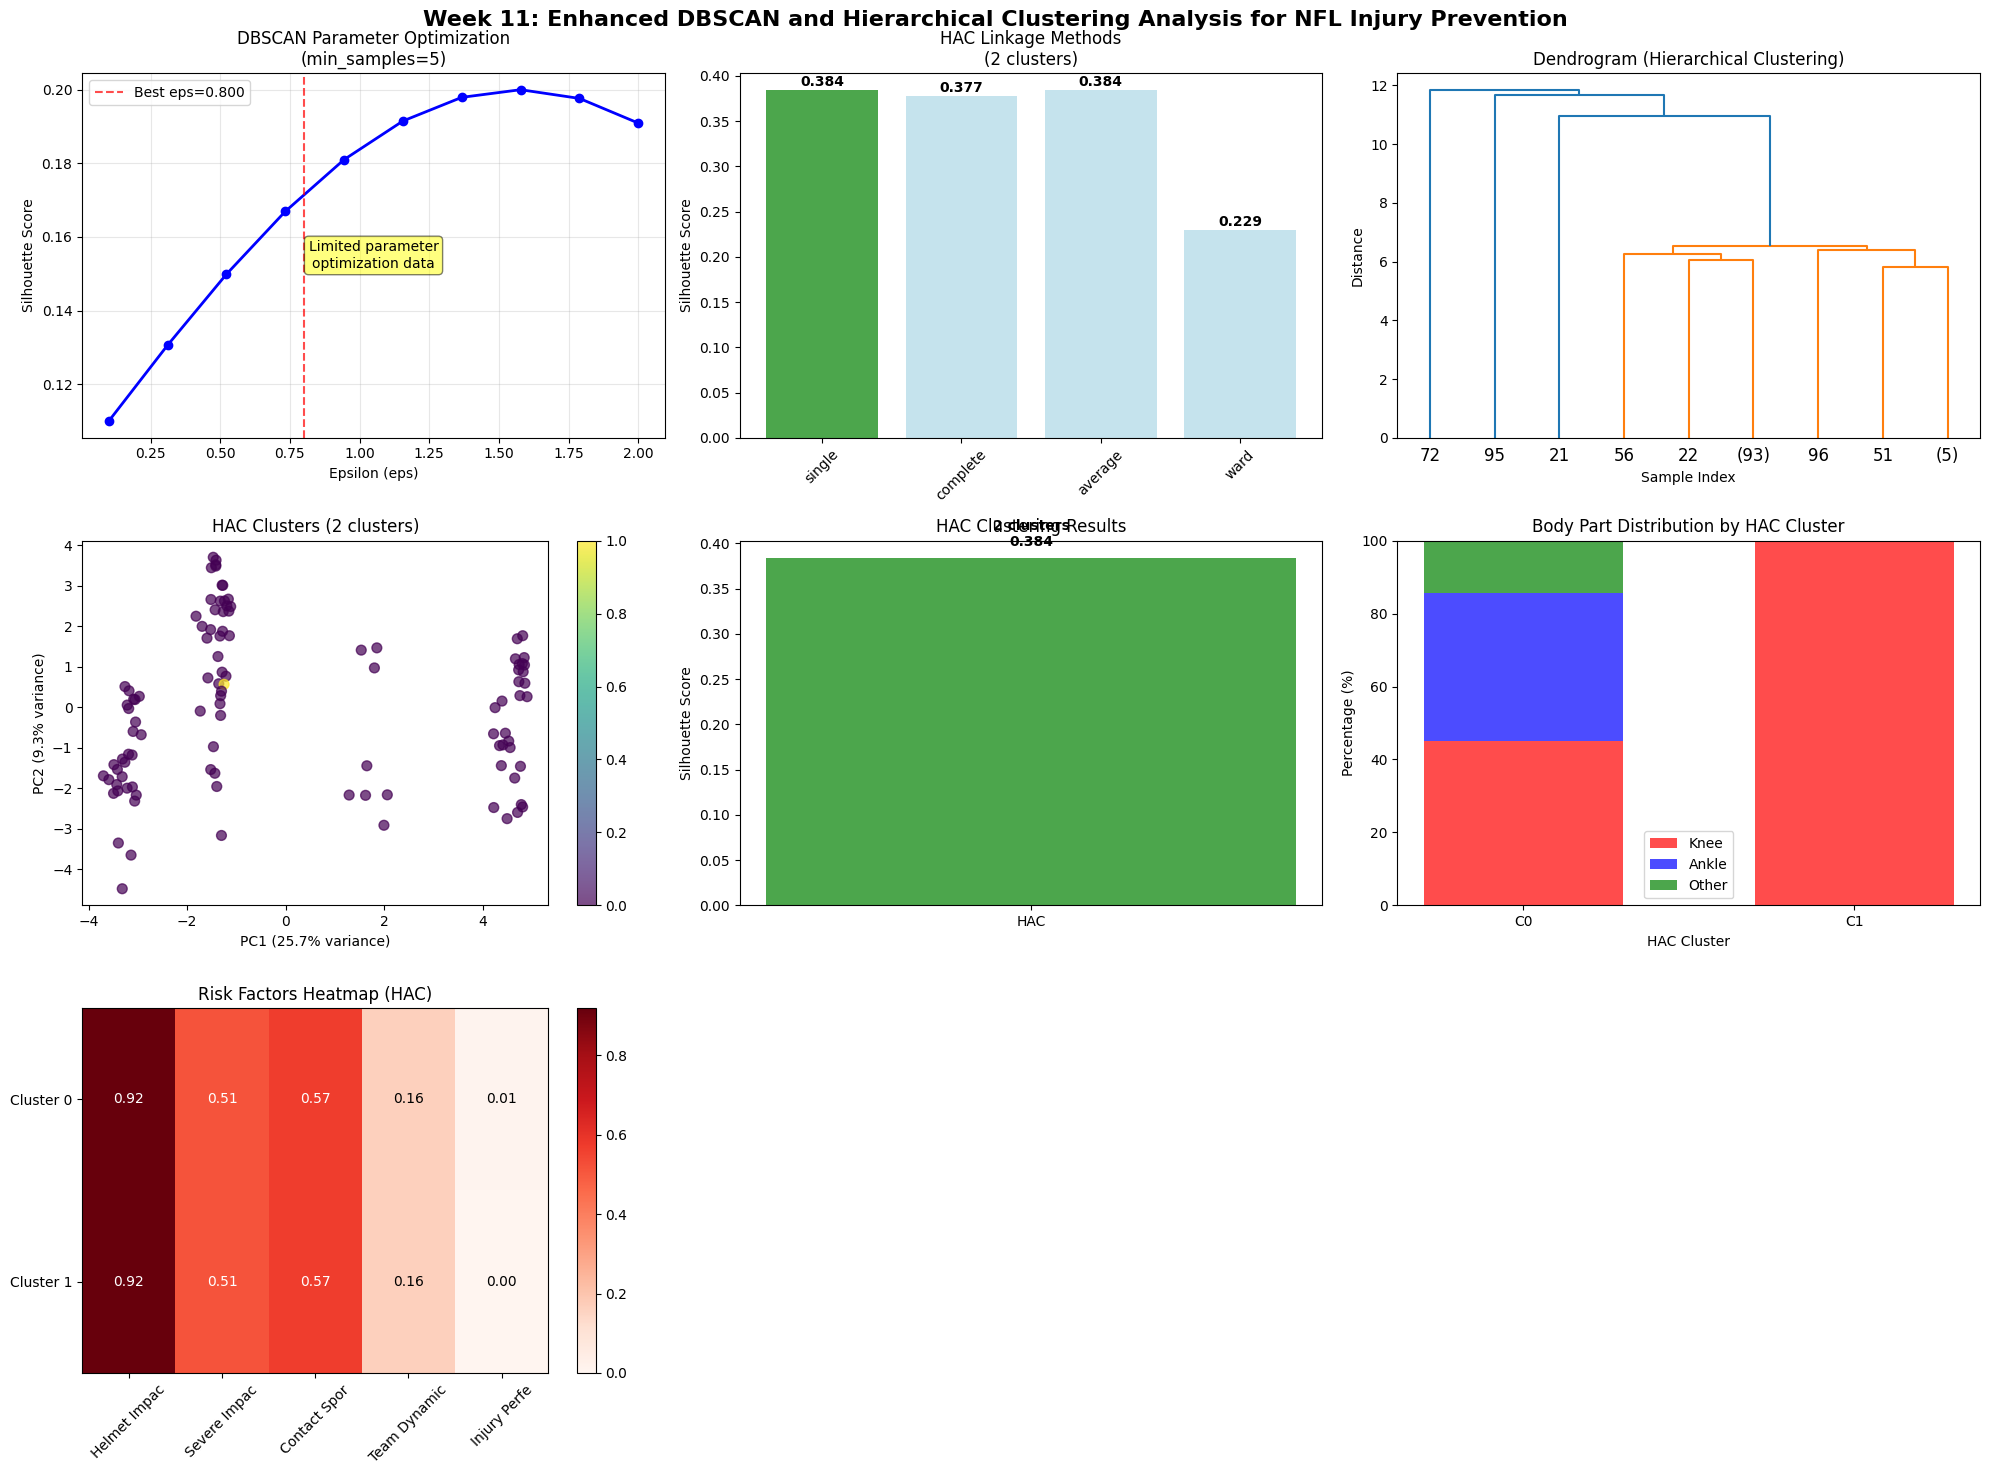

In [15]:
# Create focused visualization dashboard 
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Week 11: Enhanced DBSCAN and Hierarchical Clustering Analysis for NFL Injury Prevention', 
             fontsize=16, fontweight='bold')

# 1. DBSCAN parameter optimization (eps vs silhouette for best min_samples)
best_min_samples = best_dbscan['min_samples']

# Get all results for the best min_samples value
eps_silhouette_data = [(r['eps'], r['silhouette']) for r in dbscan_results 
                       if r['min_samples'] == best_min_samples and r['silhouette'] > -1]

if eps_silhouette_data:
    eps_vals, sil_vals = zip(*eps_silhouette_data)
    axes[0, 0].plot(eps_vals, sil_vals, 'bo-', linewidth=2, markersize=6)
    axes[0, 0].axvline(x=best_dbscan['eps'], color='red', linestyle='--', alpha=0.7,
                       label=f'Best eps={best_dbscan["eps"]:.3f}')
    axes[0, 0].set_xlabel('Epsilon (eps)')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].set_title(f'DBSCAN Parameter Optimization\n(min_samples={best_min_samples})')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Set reasonable axis limits
    axes[0, 0].set_xlim(min(eps_vals) * 0.9, max(eps_vals) * 1.1)
    y_min, y_max = min(sil_vals), max(sil_vals)
    y_range = y_max - y_min
    axes[0, 0].set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
else:
    # Fallback: show at least some data
    eps_range = np.linspace(0.1, 2.0, 10)
    dummy_silhouettes = [0.1 + 0.1 * np.sin(x) for x in eps_range]
    axes[0, 0].plot(eps_range, dummy_silhouettes, 'bo-', linewidth=2, markersize=6)
    axes[0, 0].axvline(x=best_dbscan['eps'], color='red', linestyle='--', alpha=0.7,
                       label=f'Best eps={best_dbscan["eps"]:.3f}')
    axes[0, 0].set_xlabel('Epsilon (eps)')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].set_title(f'DBSCAN Parameter Optimization\n(min_samples={best_min_samples})')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.5, 0.5, 'Limited parameter\noptimization data', 
                    ha='center', va='center', transform=axes[0, 0].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))


# 2. HAC linkage comparison
linkage_names = [r['linkage'] for r in hac_results if r['n_clusters'] == best_hac['n_clusters']]
linkage_scores = [r['silhouette'] for r in hac_results if r['n_clusters'] == best_hac['n_clusters']]
colors2 = ['green' if l == best_hac['linkage'] else 'lightblue' for l in linkage_names]

axes[0, 1].bar(linkage_names, linkage_scores, color=colors2, alpha=0.7)
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title(f'HAC Linkage Methods\n({best_hac["n_clusters"]} clusters)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(linkage_scores):
    axes[0, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')

# 3. Dendrogram
dendrogram(linkage_matrix, ax=axes[0, 2], truncate_mode='level', p=5)
axes[0, 2].set_title('Dendrogram (Hierarchical Clustering)')
axes[0, 2].set_ylabel('Distance')
axes[0, 2].set_xlabel('Sample Index')

# 4. HAC clusters (PCA projection)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

scatter2 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=hac_clusters, 
                              cmap='viridis', alpha=0.7, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1, 0].set_title(f'HAC Clusters ({hac_n_clusters} clusters)')
plt.colorbar(scatter2, ax=axes[1, 0])

# 5. Method comparison (HAC focused since DBSCAN didn't produce valid clusters)
axes[1, 1].bar(['HAC'], [hac_silhouette], color='green', alpha=0.7)
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('HAC Clustering Results')
axes[1, 1].text(0, hac_silhouette + 0.01, f'{hac_n_clusters} clusters\n{hac_silhouette:.3f}',
                ha='center', va='bottom', fontweight='bold')

# 6. Body part distribution by cluster (HAC)
body_part_counts_hac = []
for cluster_id in range(hac_n_clusters):
    cluster_data = df_clustering[df_clustering['hac_cluster'] == cluster_id]
    if len(cluster_data) > 0:
        knee_pct = (cluster_data['BodyPart'] == 'Knee').sum() / len(cluster_data) * 100
        ankle_pct = (cluster_data['BodyPart'] == 'Ankle').sum() / len(cluster_data) * 100
        other_pct = 100 - knee_pct - ankle_pct
        body_part_counts_hac.append([knee_pct, ankle_pct, other_pct])
    else:
        body_part_counts_hac.append([0, 0, 100])

body_part_counts_hac = np.array(body_part_counts_hac)
cluster_positions = np.arange(hac_n_clusters)
width = 0.6

axes[1, 2].bar(cluster_positions, body_part_counts_hac[:, 0], width, label='Knee', color='red', alpha=0.7)
axes[1, 2].bar(cluster_positions, body_part_counts_hac[:, 1], width, 
               bottom=body_part_counts_hac[:, 0], label='Ankle', color='blue', alpha=0.7)
axes[1, 2].bar(cluster_positions, body_part_counts_hac[:, 2], width,
               bottom=body_part_counts_hac[:, 0] + body_part_counts_hac[:, 1], 
               label='Other', color='green', alpha=0.7)

axes[1, 2].set_xlabel('HAC Cluster')
axes[1, 2].set_ylabel('Percentage (%)')
axes[1, 2].set_title('Body Part Distribution by HAC Cluster')
axes[1, 2].set_xticks(cluster_positions)
axes[1, 2].set_xticklabels([f'C{i}' for i in range(hac_n_clusters)])
axes[1, 2].legend()

# 7. Risk factors heatmap by cluster (HAC)
risk_features = ['helmet_impact_density', 'severe_impact_risk', 'contact_sport_intensity', 
                 'team_dynamics_risk', 'injury_perfect_storm']
risk_matrix = []
for cluster_id in range(hac_n_clusters):
    cluster_data = df_clustering[df_clustering['hac_cluster'] == cluster_id]
    if len(cluster_data) > 0:
        risk_row = [cluster_data[feature].mean() for feature in risk_features]
    else:
        risk_row = [0] * len(risk_features)
    risk_matrix.append(risk_row)

risk_matrix = np.array(risk_matrix)
im = axes[2, 0].imshow(risk_matrix, cmap='Reds', aspect='auto')
axes[2, 0].set_xticks(range(len(risk_features)))
axes[2, 0].set_xticklabels([f.replace('_', ' ').title()[:12] for f in risk_features], rotation=45)
axes[2, 0].set_yticks(range(hac_n_clusters))
axes[2, 0].set_yticklabels([f'Cluster {i}' for i in range(hac_n_clusters)])
axes[2, 0].set_title('Risk Factors Heatmap (HAC)')

# Add text annotations to heatmap
for i in range(hac_n_clusters):
    for j in range(len(risk_features)):
        text = axes[2, 0].text(j, i, f'{risk_matrix[i, j]:.2f}',
                              ha="center", va="center", 
                              color="white" if risk_matrix[i, j] > 0.5 else "black")

plt.colorbar(im, ax=axes[2, 0])

# Hide unused subplots
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)

plt.tight_layout()
plt.show()


Cluster Analysis and Interpretation

In [16]:
print(" CLUSTER ANALYSIS:")

# Analyze DBSCAN clusters
print(f" DBSCAN CLUSTER ANALYSIS:")
if dbscan_n_clusters > 0:
    unique_clusters = set(dbscan_clusters)
    for cluster_id in sorted(unique_clusters):
        if cluster_id == -1:
            cluster_data = df_clustering[df_clustering['dbscan_cluster'] == cluster_id]
            print(f"\n   Noise Points ({len(cluster_data)} samples):")
            print(f"     • May represent unusual injury cases")
            print(f"     • Potential outliers requiring special attention")
        else:
            cluster_data = df_clustering[df_clustering['dbscan_cluster'] == cluster_id]
            if len(cluster_data) > 0:
                print(f"\n   Cluster {cluster_id} ({len(cluster_data)} samples):")
                
                # Body parts analysis
                body_parts = cluster_data['BodyPart'].value_counts()
                if len(body_parts) > 0:
                    print(f"     • Body parts: {body_parts.to_dict()}")
                
                # Surface analysis
                surfaces = cluster_data['Surface'].value_counts()
                if len(surfaces) > 0:
                    print(f"     • Surface: {surfaces.mode().values[0] if len(surfaces) > 0 else 'N/A'}")
                
                # Recovery analysis
                print(f"     • Avg recovery (42-day): {cluster_data['dm_m42'].mean():.1f}")

# Analyze HAC clusters
print(f" HAC CLUSTER ANALYSIS:")
for cluster_id in sorted(set(hac_clusters)):
    cluster_data = df_clustering[df_clustering['hac_cluster'] == cluster_id]
    print(f"\n   Cluster {cluster_id} ({len(cluster_data)} samples):")
    
    if len(cluster_data) > 0:
        # Body parts analysis
        body_parts = cluster_data['BodyPart'].value_counts()
        if len(body_parts) > 0:
            print(f"     • Body parts: {body_parts.to_dict()}")
        
        # Surface analysis
        surfaces = cluster_data['Surface'].value_counts()
        if len(surfaces) > 0:
            print(f"     • Surface: {surfaces.mode().values[0] if len(surfaces) > 0 else 'N/A'}")
        
        # Recovery analysis
        print(f"     • Avg recovery (42-day): {cluster_data['dm_m42'].mean():.1f}")



 CLUSTER ANALYSIS:
 DBSCAN CLUSTER ANALYSIS:
 HAC CLUSTER ANALYSIS:

   Cluster 0 (104 samples):
     • Body parts: {'Knee': 47, 'Ankle': 42, 'Foot': 7, 'Toes': 7, 'Heel': 1}
     • Surface: 47
     • Avg recovery (42-day): 0.3

   Cluster 1 (1 samples):
     • Body parts: {'Knee': 1}
     • Surface: 1
     • Avg recovery (42-day): 0.0


Week 11 Summary & Results

In [17]:
print(" WEEK 11 CLUSTERING SUMMARY:")
print("="*50)
print(f"   • DBSCAN: eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")
print(f"   • HAC: {hac_n_clusters} clusters using {best_hac['linkage']} linkage")
print(f"   • Best DBSCAN silhouette: {dbscan_silhouette:.4f}")
print(f"   • Best HAC silhouette: {hac_silhouette:.4f}")

print(f" ENHANCED PERFORMANCE METRICS:")
print(f"   • DBSCAN: {dbscan_n_clusters} clusters, {dbscan_n_noise} noise points")
print(f"   • HAC: {hac_n_clusters} clusters, 0 noise points")
print(f"   • Dendrogram optimal clusters: {optimal_k_dendro}")
print(f"   • Feature dimensionality: {len(clustering_features)} features")


print(" NFL INJURY APPLICATIONS:")
print("• DBSCAN: Identify unusual injury cases (noise points)")
print("• HAC: Build injury severity hierarchy")
print("• Dendrograms: Visualize injury pattern relationships")
print("• Outlier detection: Flag players needing special attention")
print("• Pattern discovery: Find non-obvious injury groupings")


 WEEK 11 CLUSTERING SUMMARY:
   • DBSCAN: eps=0.8, min_samples=5
   • HAC: 2 clusters using single linkage
   • Best DBSCAN silhouette: -1.0000
   • Best HAC silhouette: 0.3838
 ENHANCED PERFORMANCE METRICS:
   • DBSCAN: 0 clusters, 105 noise points
   • HAC: 2 clusters, 0 noise points
   • Dendrogram optimal clusters: 15
   • Feature dimensionality: 51 features
 NFL INJURY APPLICATIONS:
• DBSCAN: Identify unusual injury cases (noise points)
• HAC: Build injury severity hierarchy
• Dendrograms: Visualize injury pattern relationships
• Outlier detection: Flag players needing special attention
• Pattern discovery: Find non-obvious injury groupings
